In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from models import *
from iminuit import Minuit
from iminuit.cost import LeastSquares
import random

# Testing the generated function

In the notebook Build_function.ipynb we have build a function that should compete with Bazin in fitting lightcurves. Let's us see how it behaves on data it was not trained on.<br>

## Prepare the data

First let's load the databases and apply the same transformation as in the previous notebook

In [2]:
data_raw = pd.read_csv('data/RESSPECT_PERFECT_LIGHTCURVE.csv')
meta_raw = pd.read_csv('data/RESSPECT_PERFECT_HEAD.csv')

all_obj = np.unique(data_raw['SNID'])

/media3/etienne/genetic_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Normalize flux 
maxtable = data_raw.pivot_table(index="FLT", columns="SNID", values="FLUXCAL",aggfunc='max')
maxdf = pd.DataFrame(data=maxtable.unstack())
clean = pd.merge(maxdf, data_raw, on=["SNID","FLT"])
clean["FLUXCAL"] = clean["FLUXCAL"]/clean[0]
clean["FLUXCALERR"] = clean["FLUXCALERR"] / clean[0]
clean = clean.drop([0],axis=1)

# Shift mjd
mintable = clean.pivot_table(index="FLT", columns="SNID", values="MJD",aggfunc='min')
mindf = pd.DataFrame(data=mintable.unstack())
clean = pd.merge(mindf, clean, on=["SNID","FLT"])
clean["MJD"] = clean["MJD"]-clean[0]
clean = clean.drop([0],axis=1)

# Normalize mjd
maxtable = clean.pivot_table(index="FLT", columns="SNID", values="MJD",aggfunc='max')
maxdf = pd.DataFrame(data=maxtable.unstack())
clean = pd.merge(maxdf, clean, on=["SNID","FLT"])
clean["MJD"] = clean["MJD"]/clean[0]
clean = clean.drop([0],axis=1)

We will also define a quick function that returns the points of a lightcurve based on it's ID and passband while also adding the zeros points

In [35]:
def get_obj(snid,flt):
    
    obj = clean[(clean['SNID']==snid)&(clean['FLT']==flt)]
    mjd = obj['MJD']
    flux = obj['FLUXCAL']
    fluxerr = obj['FLUXCALERR']
    target = meta_raw.loc[meta_raw['SNID']== snid, 'type'].iloc[0]

    # Add zero points far away
    mjd = mjd.append(pd.Series([-1,-2,-3,2,3,4]),ignore_index=True)
    flux = flux.append(pd.Series([0,0,0,0,0,0]),ignore_index=True)
    fluxerr = fluxerr.append(pd.Series([0.001]*6),ignore_index=True)
    
    return mjd,flux,fluxerr,target


In [36]:
nb_obj = len(meta_raw)
all_type = np.unique(meta_raw['type'])

print('Lets have a look at the metadata !\n')
print('There are %s all_obj in the database\nFor a total of %s classes :\n%s'%(nb_obj,len(all_type),meta_raw['type'].value_counts()))
print('\nNow since each type of supernoave acts diffrently, we might want to fit each type')

Lets have a look at the metadata !

There are 4000 all_obj in the database
For a total of 8 classes :
Ia            800
Iax           800
91bg          800
Ibc_V19       555
II_V19        308
II-NMF        291
Ibc-MOSFIT    245
IIn           201
Name: type, dtype: int64

Now since each type of supernoave acts diffrently, we might want to fit each type


## First compare

We create a function that does a comparison of our function vs bazin given the SNID and the passband that we want

In [37]:
def compare(snid,flt,size=(28,9)):
    
    fit_color = 'red'
    guess_color = 'lightgray'
    
    mjd,flux,fluxerr,target = get_obj(snid,flt)
    peak_mjd = mjd[np.argmax(flux)]
    
    guess_bazin = [1, peak_mjd, 0.2, -0.05, 0]
    guess_ego = [0.865,2.496,0.912,-49.28,0.906,0.125,-peak_mjd]

    x_fit = np.linspace(mjd.min(),mjd.max(),500)

    fig = plt.figure(figsize=size)
    plt.suptitle(f'Lightcurve SNID : {snid}, passband : {flt}, type : {target}',fontsize = size[0])


    ## BAZIN FIT ##############################
    plt.subplot(1, 2, 1)

    least_squares = LeastSquares(mjd,flux,0.01,bazin)
    m = Minuit(least_squares, p1=guess_bazin[0],p2=guess_bazin[1],p3=guess_bazin[2],p4=guess_bazin[3],p5=guess_bazin[4])  # starting values for α and β
    m.migrad()

    plt.scatter(mjd,flux)
    plt.plot(x_fit,bazin(x_fit,m.values[0],m.values[1],m.values[2],m.values[3],m.values[4]),label = 'Bazin fit', c=fit_color)
    plt.plot(x_fit,bazin(x_fit,*guess_bazin),label = 'Initial Bazin guess', c=guess_color)

    plt.title('BAZIN',size = 2*size[0]/3)
    plt.xlabel('MJD',size = size[0]/2)
    plt.ylabel('Flux',size = size[0]/2)
    plt.ylim(-0.1,1.1)
    plt.xlim(0,1)
    plt.legend(fontsize = 2*size[0]/3)

    ## OUR FIT ##############################
    plt.subplot(1, 2 ,2)

    least_squares = LeastSquares(mjd,flux,fluxerr,ego)
    m = Minuit(least_squares, p1=guess_ego[0],p2=guess_ego[1],p3=guess_ego[2],p4=guess_ego[3],p5=guess_ego[4],p6=guess_ego[5],shift=guess_ego[6])  # starting values for α and β
    m.migrad()

    plt.scatter(mjd,flux)
    plt.plot(x_fit,ego(x_fit,m.values[0],m.values[1],m.values[2],m.values[3],m.values[4],m.values[5],m.values[6]),label = 'Our fit', c=fit_color)
    plt.plot(x_fit,ego(x_fit,*guess_ego),label = 'Our initial guess', c=guess_color)

    plt.title('OUR FUNCTION',size = 2*size[0]/3)
    plt.xlabel('MJD',size = size[0]/2)
    plt.ylabel('Flux',size = size[0]/2)
    plt.ylim(-0.1,1.1)
    plt.xlim(0,1)
    plt.legend(fontsize = 2*size[0]/3)

    plt.show()

Let us first rewind the light curve it was trained on. We will choose as initial parameters the ones from the original fit and the shift parameter will always be the mjd value of the lightcurve peak.<br>
For Bazin's initial parameter we choose values that are well suited to fit lightcurves without exploding, and the second parameter is the same as the shift parameter of our function.

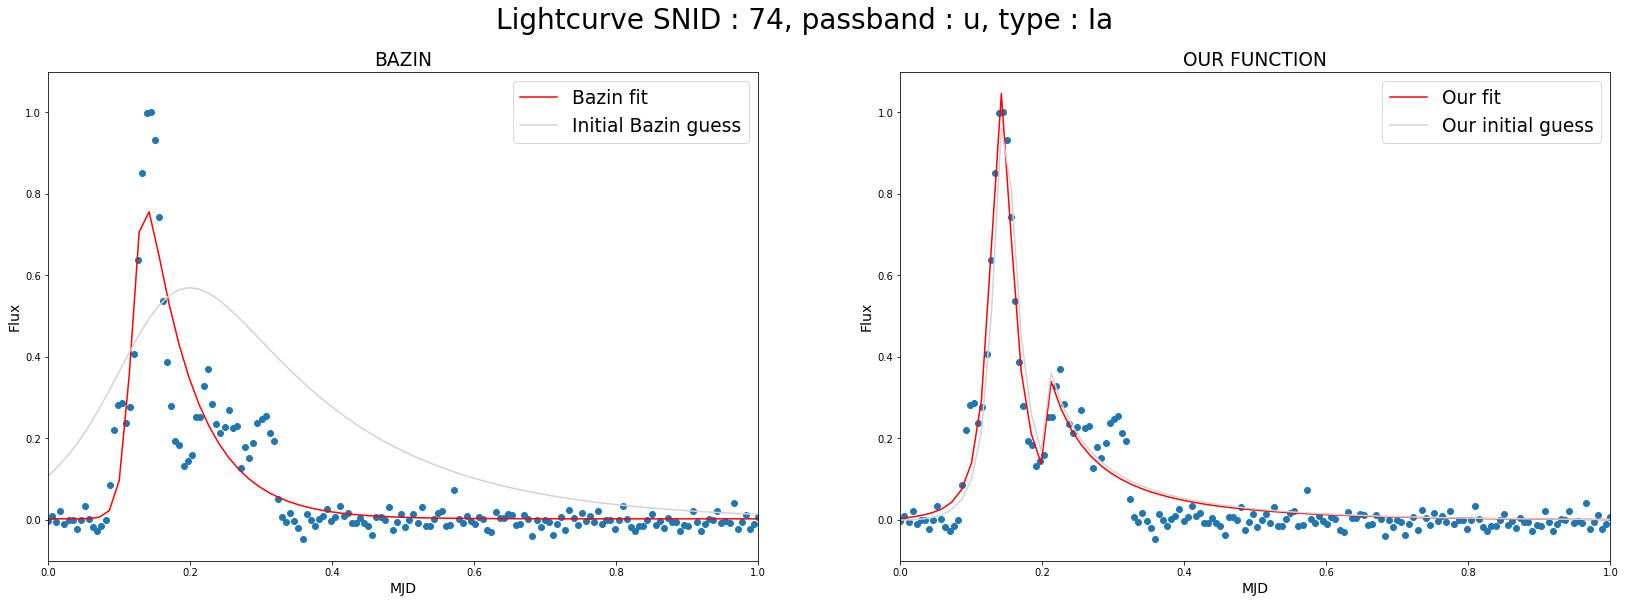

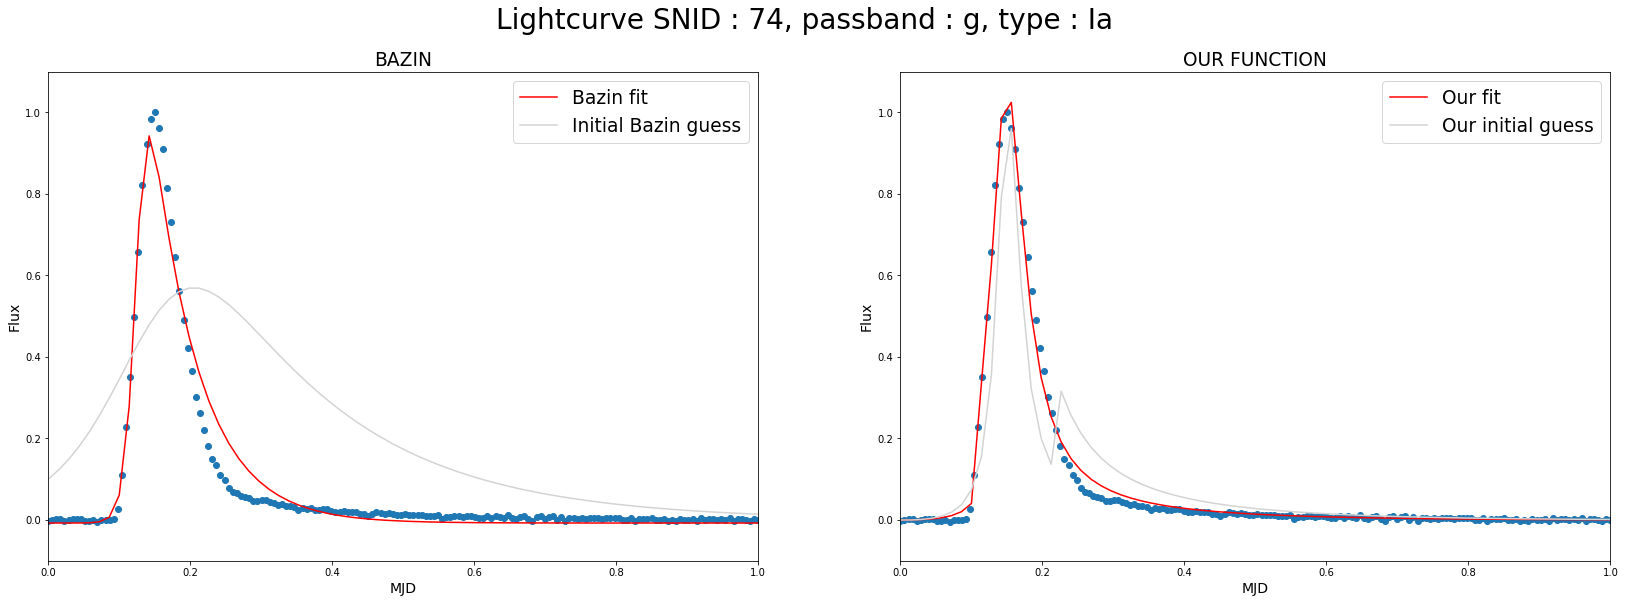

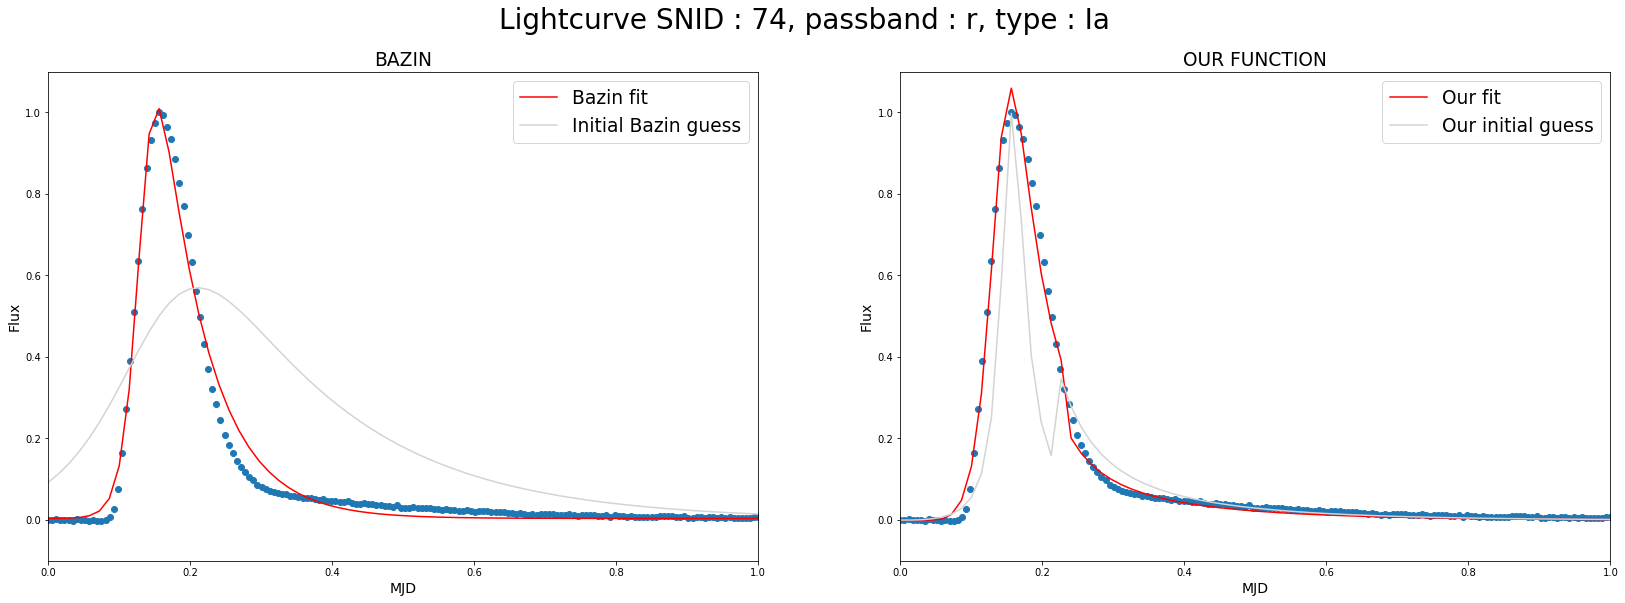

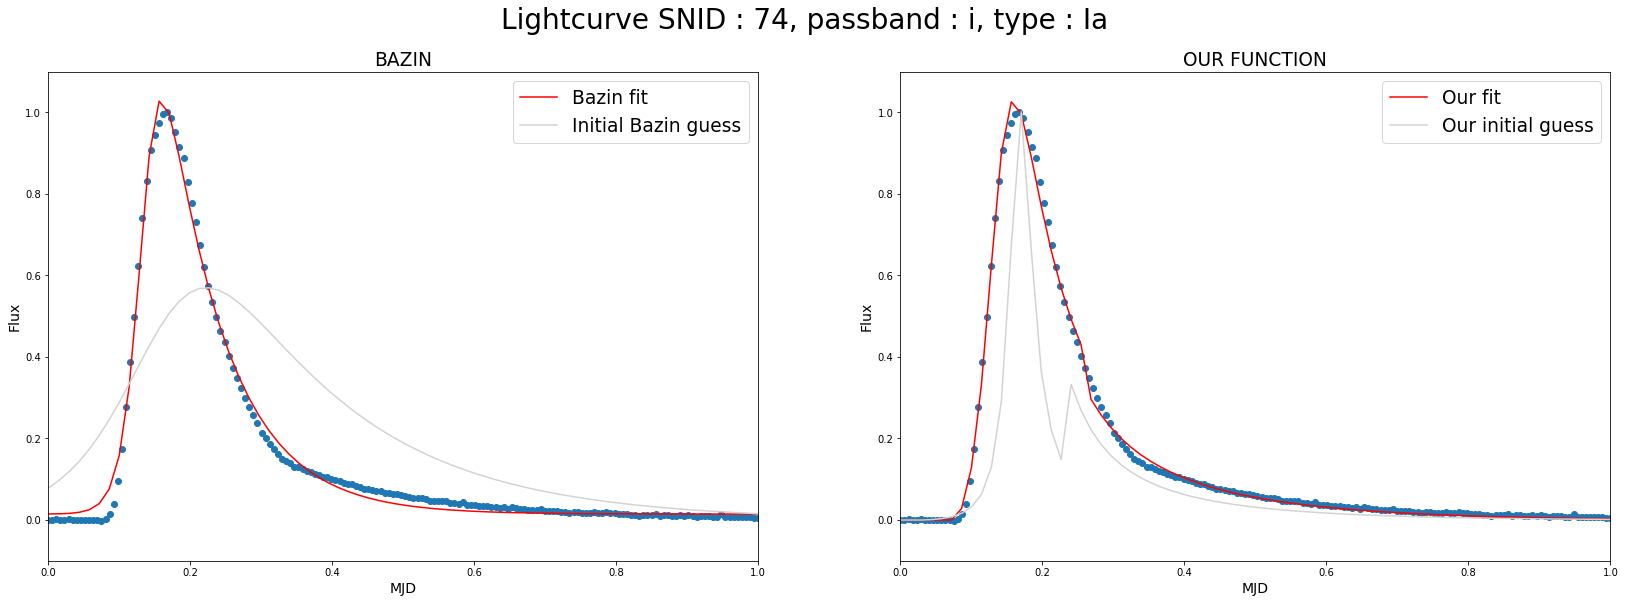

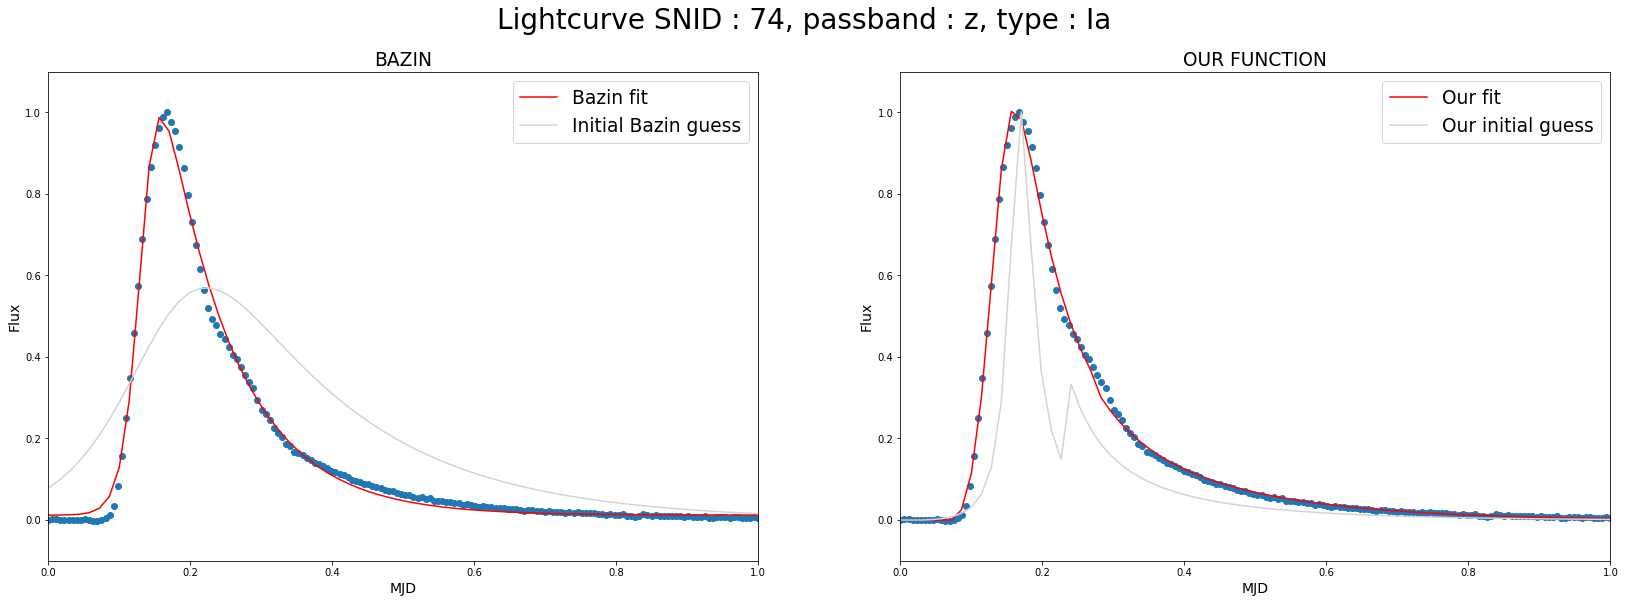

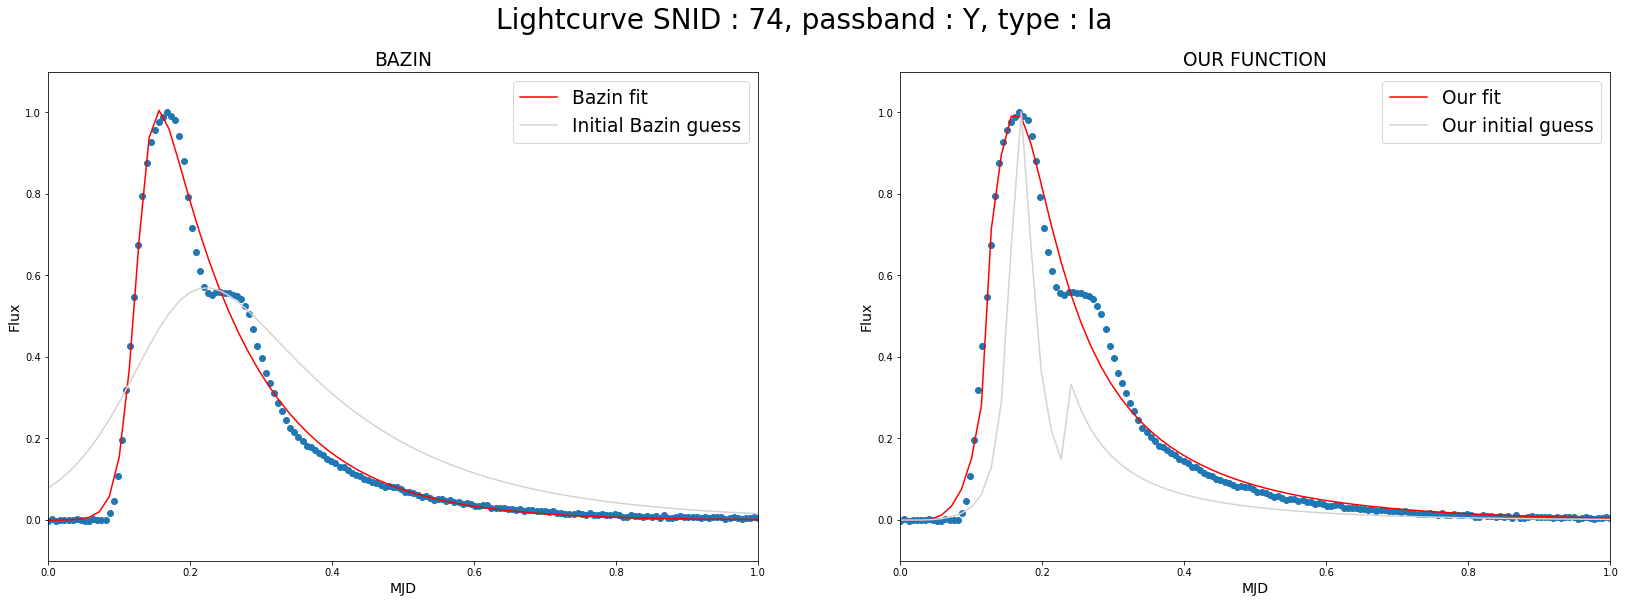

In [38]:
for i in ['u','g','r','i','z','Y']:
    compare(74,i)

Our function display very good results ! We recognize in band u our "perfect" fit against which Bazin cannot fight (it is not fair though) <br>
In band g, i, r and z we observe than even when the lightcurve has no second bump our function is perfectly capable of describing it, and here even does a better job than bazin ! <br>
Unfortunately we see in band Y that it is not perfect since it totally misses evident bump .. Still the fit is as good as Bazin at minimum.<br>

Below is cell that compares bazin with our function for random objects, you can try and see how well it behaves in this dataset ! The conclusions we draw from the above example are pretty much the same when we look at random light curves from this data set, but it appears that specific light curves that are very wide, or that display a long plateau leads to very bad fits. It must be said that Bazin is overall more stable than our function. Here is a list of object ID that leads to terrible fitting : [8150, 4837, 2046, 3686, 6205, 1734]. But the most important aspect seems to be respected since in many cases the function is capable of describing the second bump (even if the bump isnt fitting well the points, it should separate them in the parameter space)! See objects : [211, 446, 6589, 6742, 1485] <br>We can now use this function to feature extract and do some machine learning

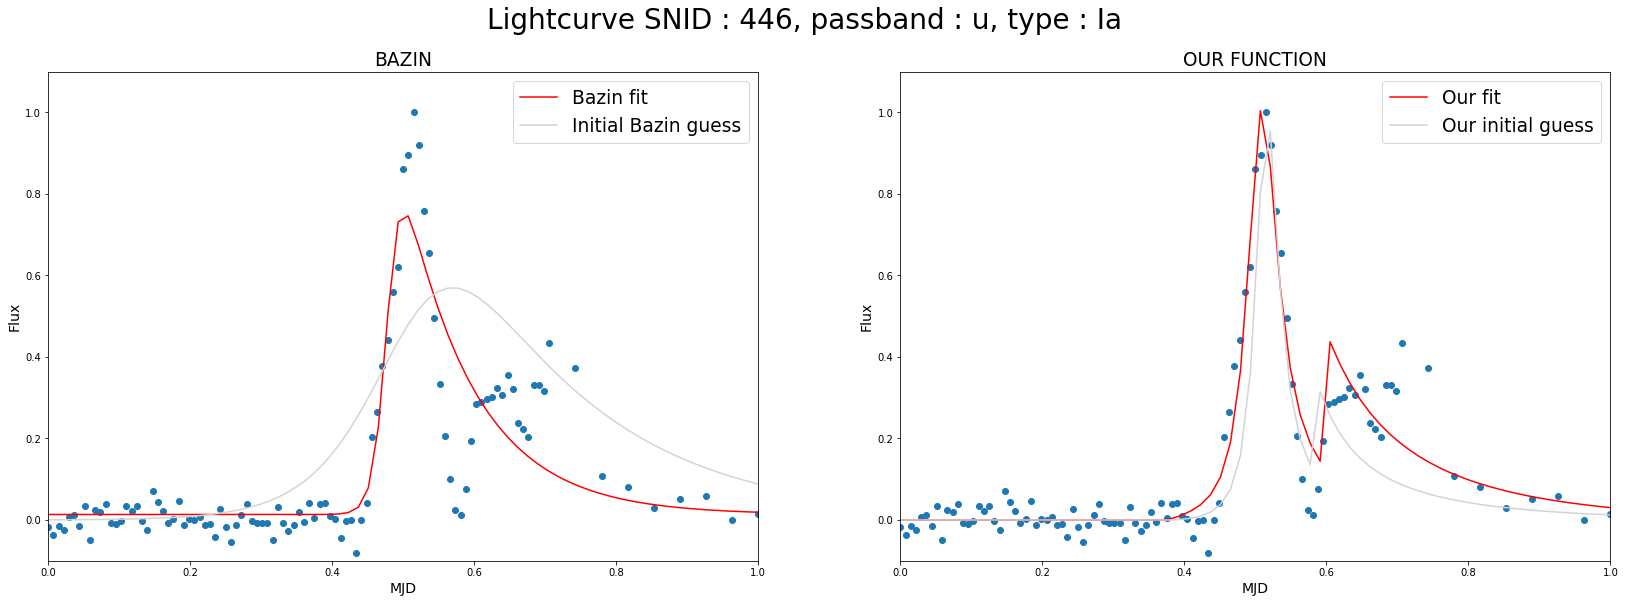

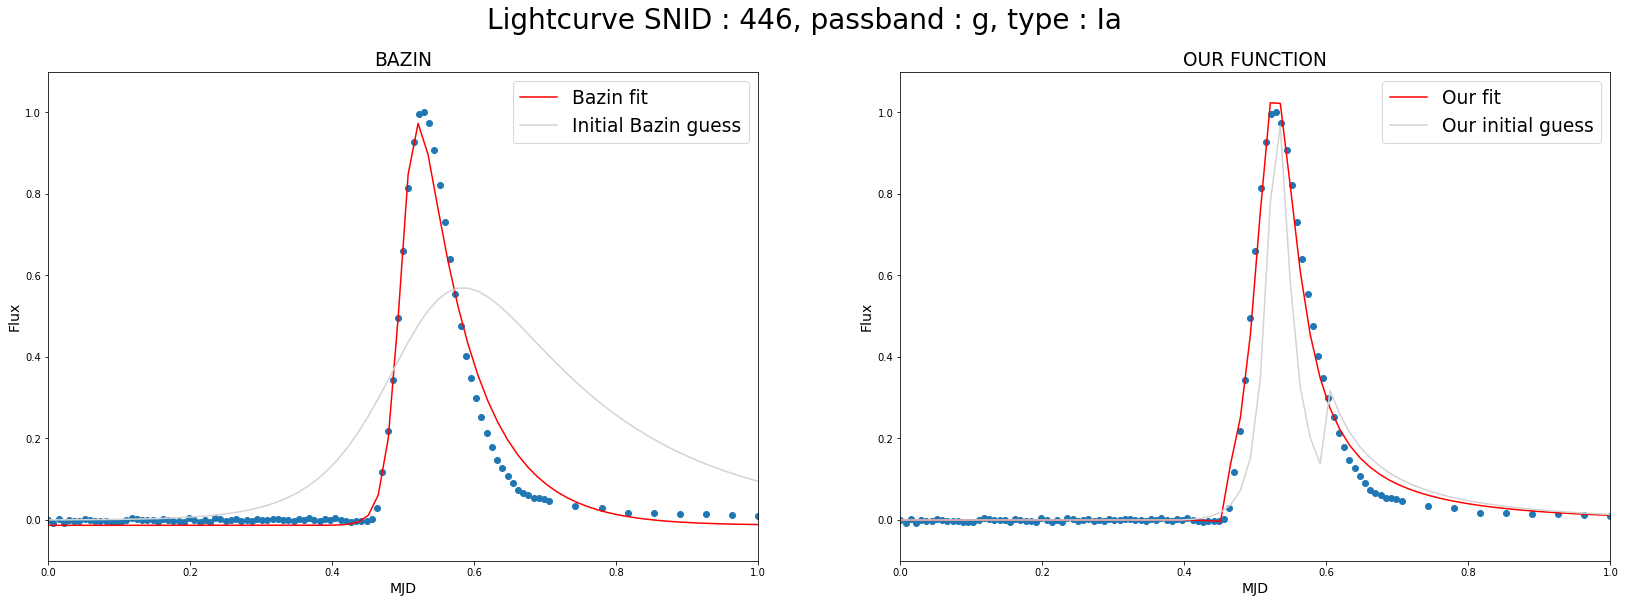

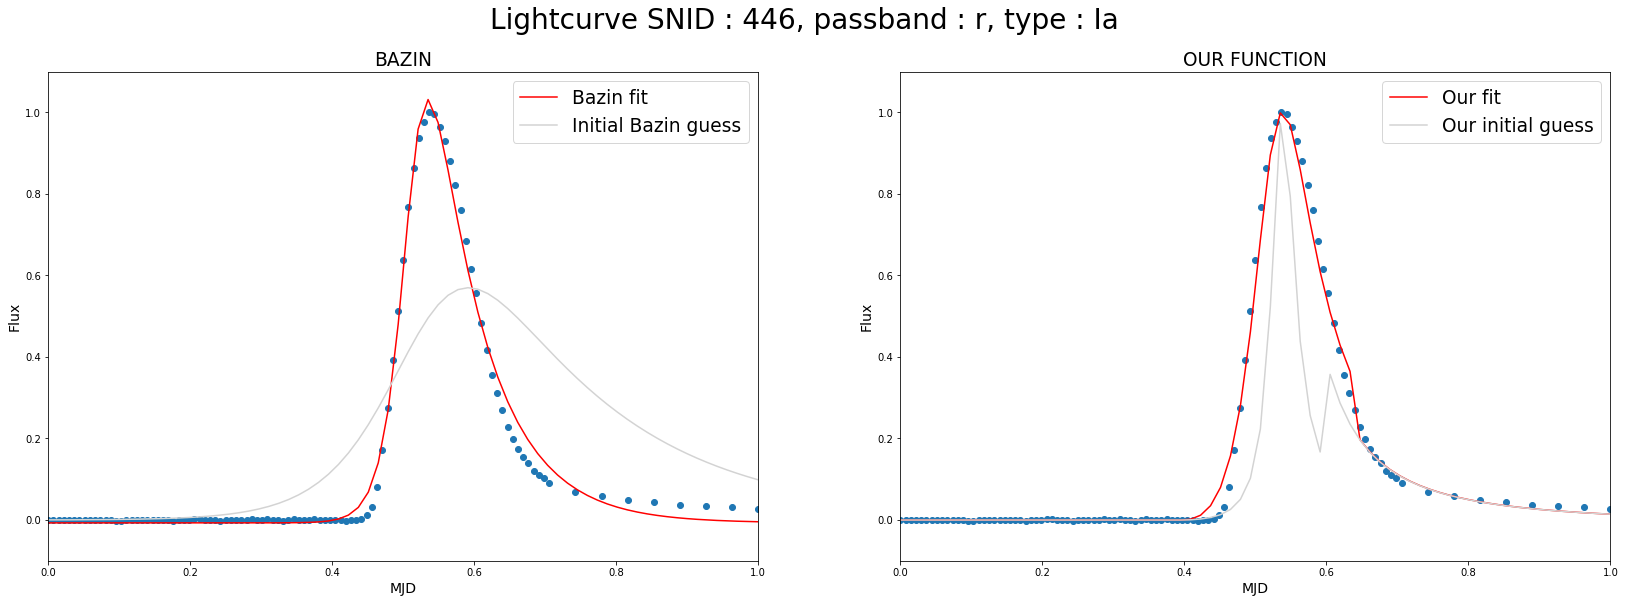

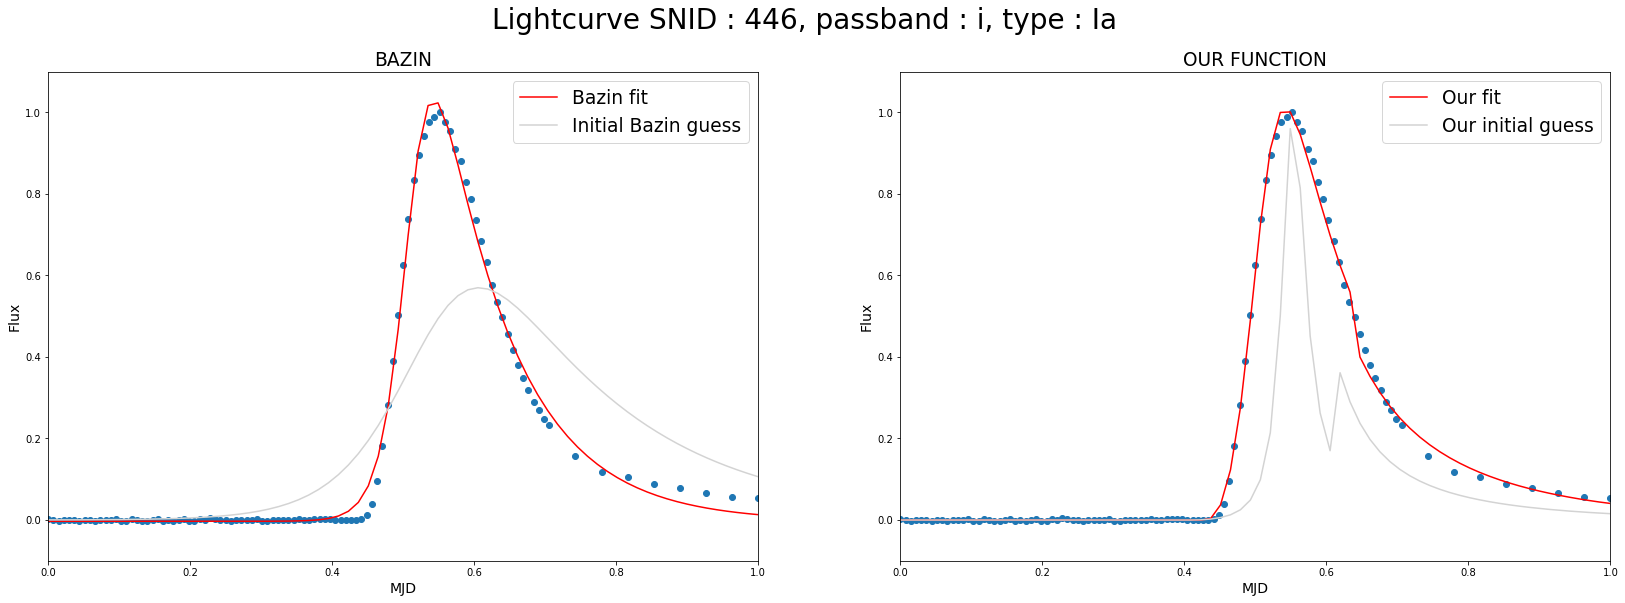

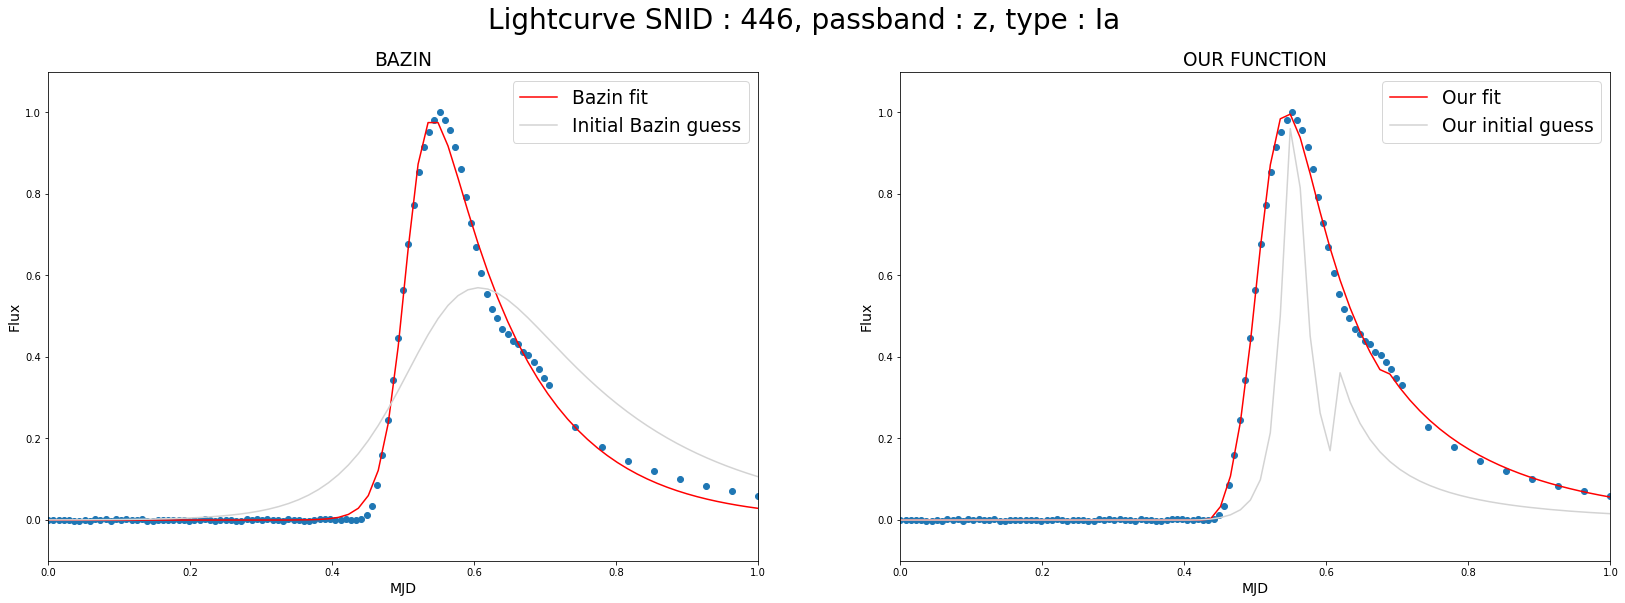

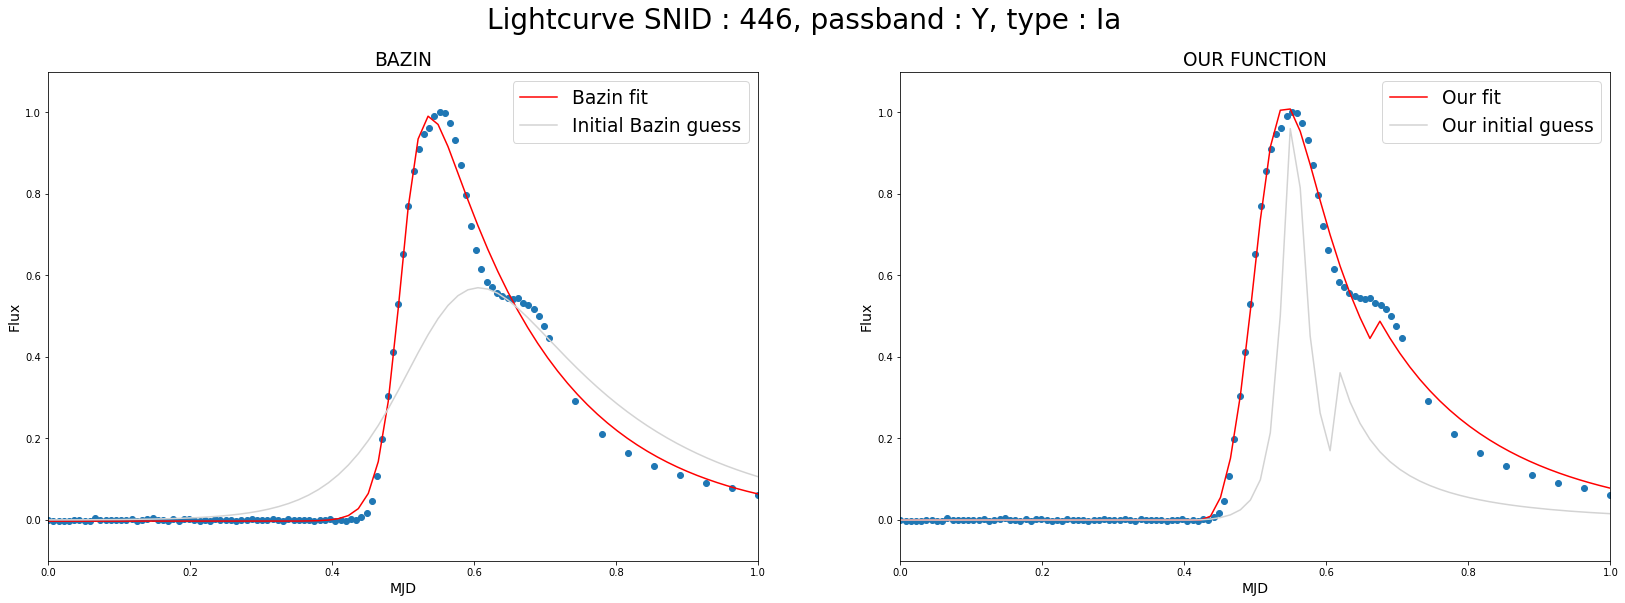

In [39]:
rand_obj = int(all_obj[random.randint(0,4000)])
rand_obj = 446
for i in ['u','g','r','i','z','Y']:
    compare(rand_obj,i)